In [54]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from scipy.misc import imread
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
import PIL
from PIL import Image

In [3]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [55]:
def importImage(pngfile):
    img = imread(pngfile, flatten=True, mode='L')
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [4]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [5]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

In [6]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [7]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [8]:
def getCropped(X, thresh=0.01):
    ll, w, h = getBoundingBox(X, thresh=thresh)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

In [9]:
def getStripBoundaries(X, showPlot = False, debug=False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1) # sum pixel values in a row
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1)) # get overall large peak from individual pixiel peaks
    # get strips by looking at center of peaks and taking midpoints
    #assert(len(peakidxs) % 2 == 0)
    
    if debug:
        print("X filter:")
        plt.imshow(Xfilt)
        print("rsum is: " +  str(rsum))
        print("rsum spectra: " + str(rsum_spectra))
        print("spectra max: " + str(spectra_max))
        print("num peak ids: " + str(len(peakidxs)))
    
    # determine boundaries
    numStrips = np.int(len(peakidxs))
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[i]
        if i >= (numStrips - 1):
            break
        peak2idx = peakidxs[i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    # we might skip some
    if debug:
        print("num boundaries: " + str(len(boundaries)))
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [10]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

In [11]:
def getStrips(X, bnds, debug=False):
    strips = []
    print("num bounds: " + str(len(bnds)))
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [12]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [13]:
def locateStaffLines(s, delta = 3, debug=False):
    medvals = np.median(s, axis=1)
    if debug:
        print("num medvals: " + str(len(medvals)))
        print("medvals are: " +  str(medvals))
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10]) # going to change from [0:10] to [0:10] skipping by 2
    idxs_lines = idxs_lines[1::2] # we want just 5, so start at the second and skip every other.
    if debug:
        print("sorted idxs val before clip: " + str(idxs_sorted_val))
        print("num sorted idxs: " + str(len(idxs_sorted_val)))
        print("idxs_lines number after clip: " + str(len(idxs_lines)))
        print("idxs_lines: " + str(idxs_lines))
    return np.array(idxs_lines)

In [14]:
def getStripBoundariesNonPiano(X, showPlot = False, debug = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    if debug:
        print("X filter:")
        plt.imshow(Xfilt)
        print("rsum is: " +  str(rsum))
        print("rsum spectra: " + str(rsum_spectra))
        print("spectra max: " + str(spectra_max))
        print("num peak ids: " + str(len(peakidxs)))
        print("peak ids: " + str(peakidxs))
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) # note the lack of -1 here
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i]
        peak2idx = peakidxs[2*i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

Now we have everything we need to get + visualize strips. That's as far as well go rn.

In [15]:
pics = os.listdir('pdf/mini_dataset_png')

In [16]:
pic_names = []
for pic in pics:
    name = os.path.join('pdf/mini_dataset_png', pic)
    pic_names.append(name)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


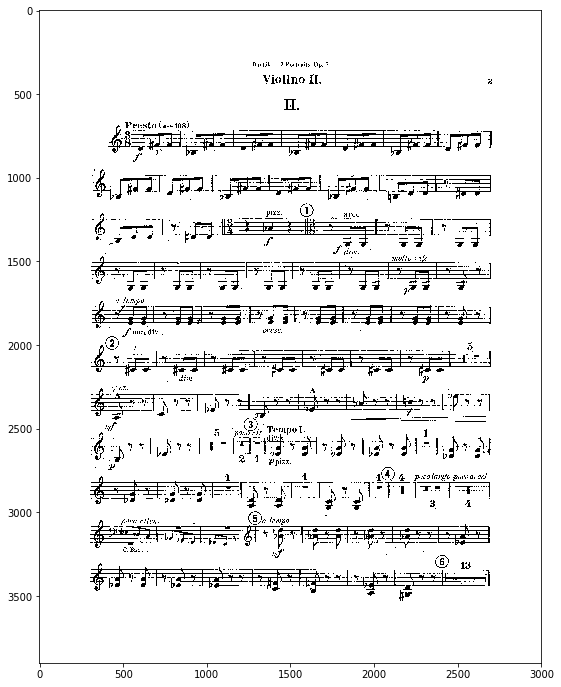

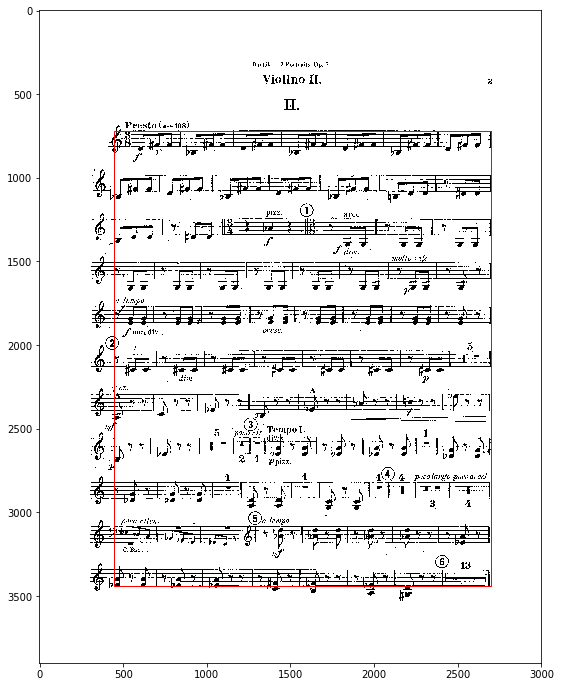

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [-4111.80096387   -84.            63.         ...  -252.
  -105.          5119.80096387]
rsum spectra: [[ -566.782  +0.0000000e+00j  -517.1142 +0.0000000e+00j
   -384.74765+0.0000000e+00j ...  3796.7769 +0.0000000e+00j
   3848.9849 +0.0000000e+00j  3796.7769 +0.0000000e+00j]
 [ 4479.082  -8.5265128e-14j  4208.4175 +1.6153112e+03j
   3417.5322 +3.0392261e+03j ... -3994.768  +8.4651178e+02j
  -4109.919  +2.1316282e-14j -3994.768  -8.4651178e+02j]
 [-8761.122  +1.4383262e-13j -8014.1665 -3.3976523e+03j
  -5949.5713 -6.1417026e+03j ...  3971.5063 -1.6403784e+03j
   4348.7217 -2.0097183e-14j  3971.5063 +1.6403784e+03j]
 ...
 [-4491.0977 +8.3541064e-14j  4061.95   -1.8292754e+03j
  -2866.6902 +3.2507959e+03j ... -4657.7065 -1.9339978e+03j
   5093.992  +2.0097183e-14j -4657.7065 +1.9339978e+03j]
 [ 3701.431  -1.9895197e-13j -3581.4287 +7.3121948e+02j
   3251.296  -1.3828302e+03j ...  4938.8374 +9.8023486e+02j
  -5082.538  +3.5527137e-14j  4938.8374 -9.8023486e+02j]
 [-3606.

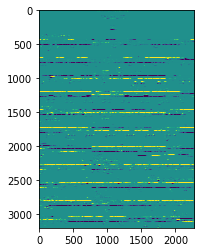

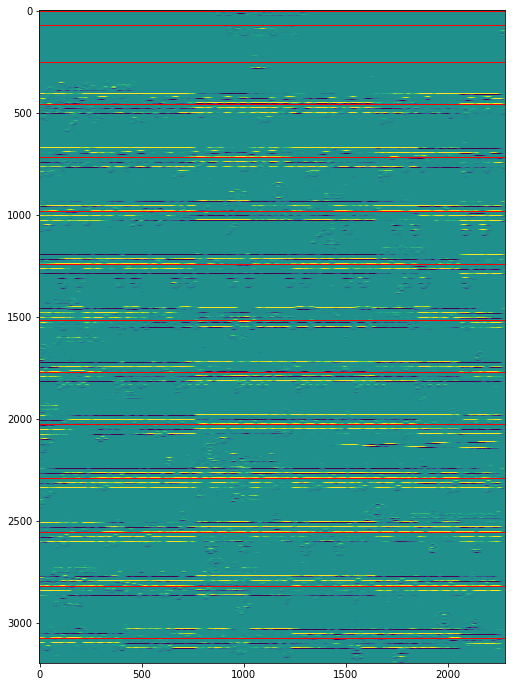

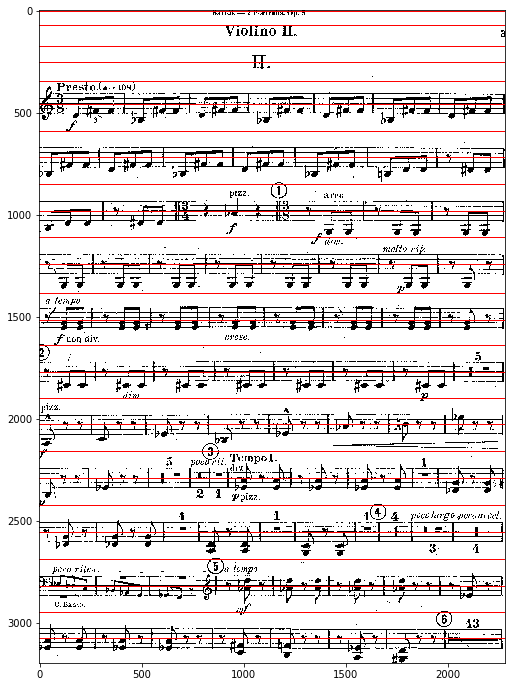

In [16]:
pic = pic_names[0]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
showImage(Irot)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot) # with default thresh
bnds = getStripBoundariesNonPiano(Icrop,debug=True)
print("visualizing boundaries...")
visualizeBoundaries(Icrop, bnds)
print("visuzlizing boundaries, piano...")
bnds_piano = getStripBoundaries(Icrop, debug=True)
visualizeBoundaries(Icrop, bnds_piano)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


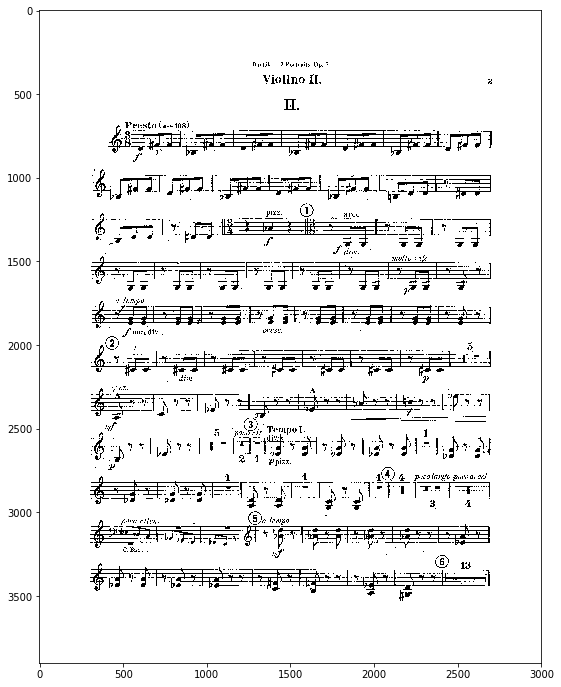

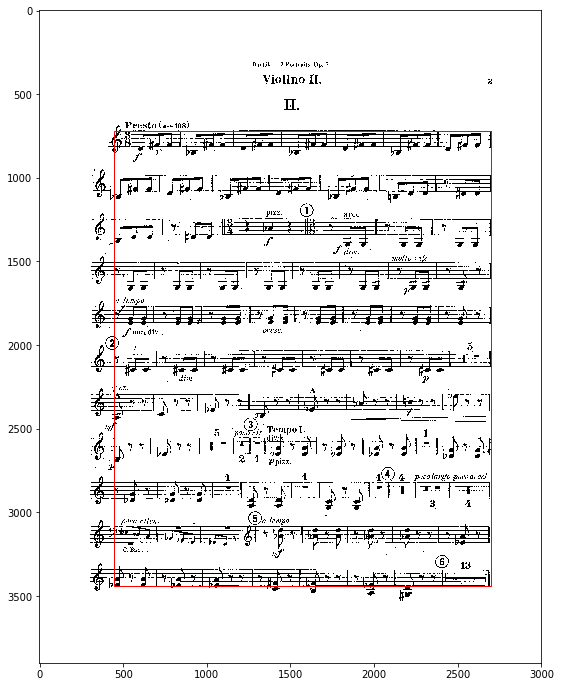

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [ 15906.07569639  23520.          19832.         ...  -6941.
 -12639.         -23607.07569639]
rsum spectra: [[-12631.58   +0.0000000e+00j -12687.675  +0.0000000e+00j
  -12833.63   +0.0000000e+00j ...  32381.066  +0.0000000e+00j
   32381.195  +0.0000000e+00j  32381.066  +0.0000000e+00j]
 [-33022.668  -4.5474735e-13j -30083.225  -1.5065120e+04j
  -21686.223  -2.7897598e+04j ...   2379.4448 -7.6919907e+03j
    3909.609  -1.0231815e-12j   2379.4448 +7.6919907e+03j]
 [122101.734  +5.1448789e-12j 108742.586  +5.4212422e+04j
   72112.445  +9.5602867e+04j ... -66619.35   +3.5081250e+04j
  -75654.38   -2.5724394e-12j -66619.35   -3.5081250e+04j]
 ...
 [  -544.1182 -5.1448789e-12j    507.22778-1.4121497e+02j
    -431.5478 +2.4408081e+02j ...  13142.269  +5.4701299e+03j
  -14355.997  +2.5724394e-12j  13142.269  -5.4701299e+03j]
 [  2451.1917 -4.0927262e-12j  -2445.2622 +1.7194127e+02j
    2405.4326 -3.4581155e+02j ... -12417.45   -2.7460547e+03j
   12842.963  -1.0231815e-12j -

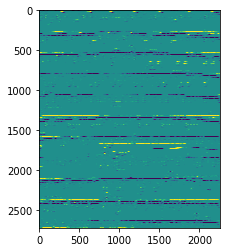

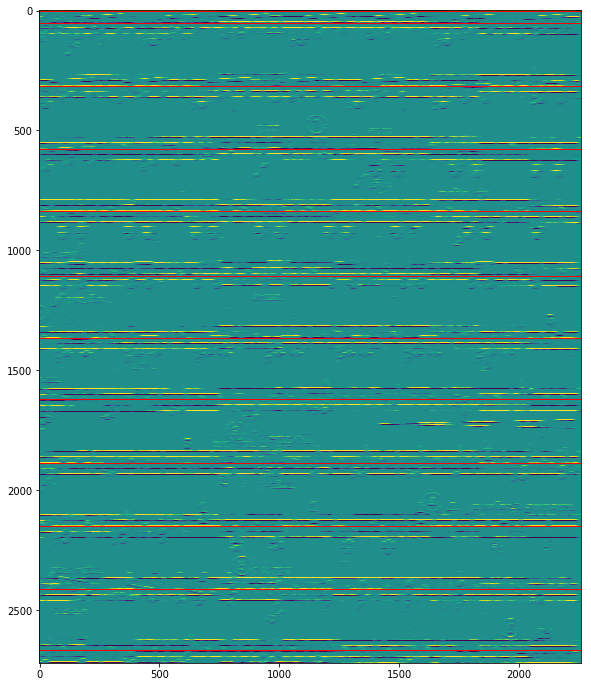

In [17]:
pic = pic_names[0]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
showImage(Irot)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot, thresh=0.2) # with 0.2 thresh
bnds = getStripBoundariesNonPiano(Icrop,debug=True)
print("visualizing boundaries...")
visualizeBoundaries(Icrop, bnds)
print("visuzlizing boundaries, piano...")
bnds_piano = getStripBoundaries(Icrop, debug=True)

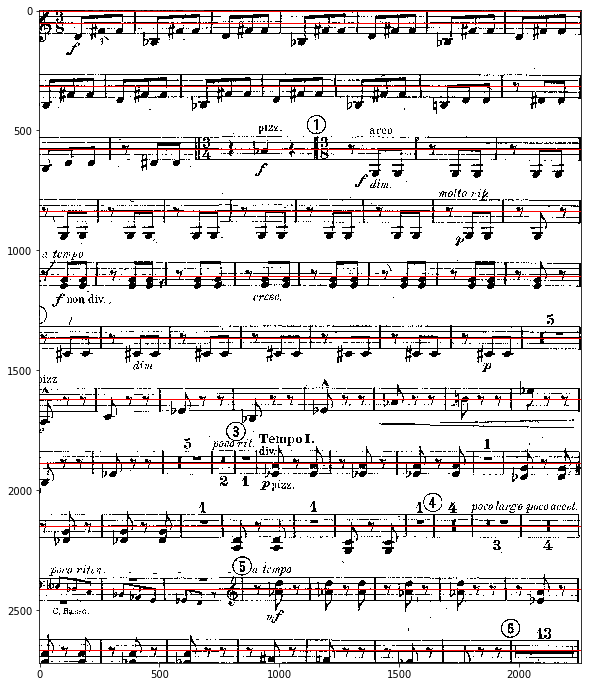

In [18]:
visualizeBoundaries(Icrop, bnds)

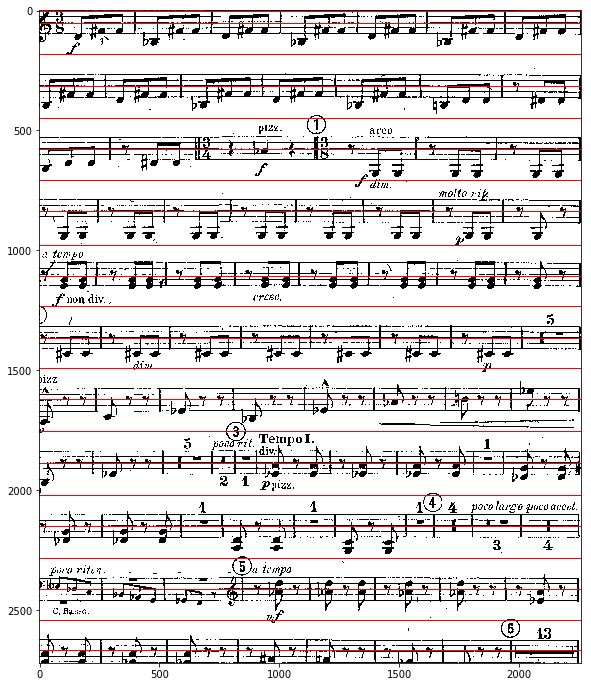

In [19]:
visualizeBoundaries(Icrop, bnds_piano)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


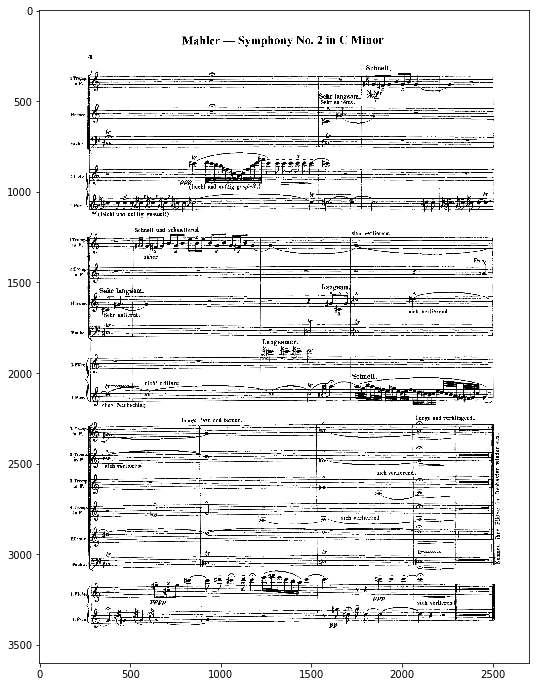

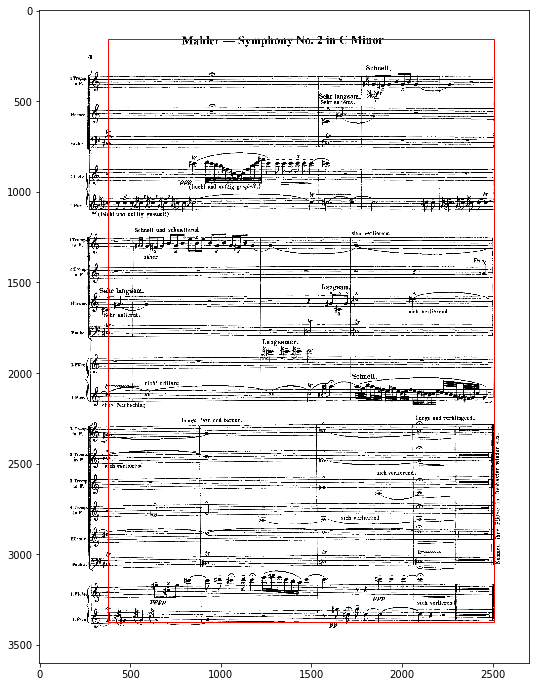

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [ 3285.13127493   288.93727783  -322.08895885 ... -1684.90056352
   253.64131325 -1833.76712586]
rsum spectra: [[  2128.584 +0.0000000e+00j   2122.0332+0.0000000e+00j
    2089.6084+0.0000000e+00j ... -12148.772 +0.0000000e+00j
  -12382.829 +0.0000000e+00j -12148.772 +0.0000000e+00j]
 [ -2023.3381+2.1316282e-14j  -1956.76  -3.6828906e+02j
   -1779.1898-6.9062012e+02j ...  21236.926 -6.1826304e+03j
   22228.084 +1.1368684e-12j  21236.926 +6.1826304e+03j]
 [  3388.9624-5.6843419e-14j   2989.0178+1.5486870e+03j
    1888.7906+2.6918684e+03j ... -23627.172 +8.3166201e+03j
  -25111.58  -1.5526046e-12j -23627.172 -8.3166201e+03j]
 ...
 [  2482.3452-5.6843419e-14j  -2249.7344+9.6068658e+02j
    1628.9198-1.6957244e+03j ...   1851.6279+7.1383704e+02j
   -1991.8279-2.6638484e-13j   1851.6279-7.1383704e+02j]
 [ -2443.7195-6.3948846e-14j   2387.3896-4.5542038e+02j
   -2210.3784+8.7779358e+02j ...  -2218.1782-4.3176318e+02j
    2291.0024-6.8212103e-13j  -2218.1782+4.3176318e+02j]


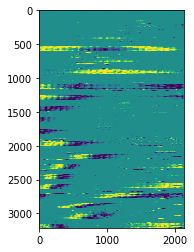

In [20]:
pic = pic_names[1]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
showImage(Irot)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot, thresh=0.2) # with 0.2 thresh
bnds = getStripBoundariesNonPiano(Icrop,debug=True)
bnds_piano = getStripBoundaries(Icrop, debug=True)

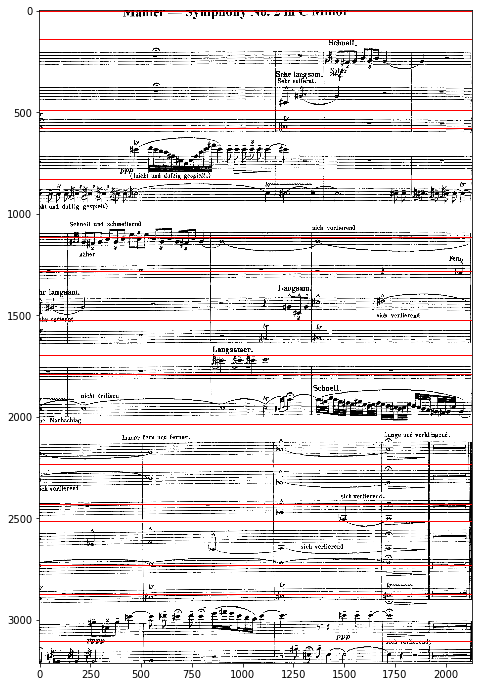

In [21]:
visualizeBoundaries(Icrop, bnds)

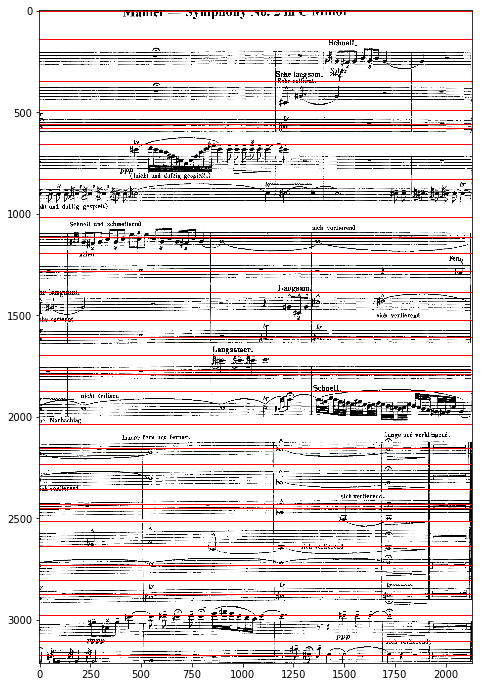

In [22]:
visualizeBoundaries(Icrop, bnds_piano)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


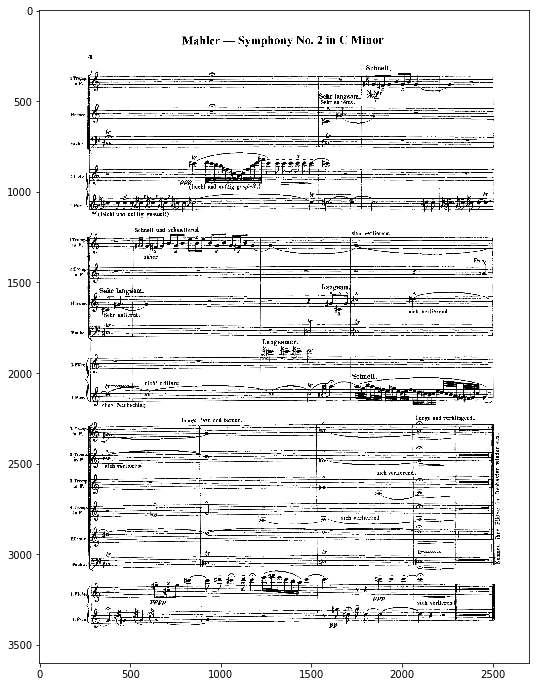

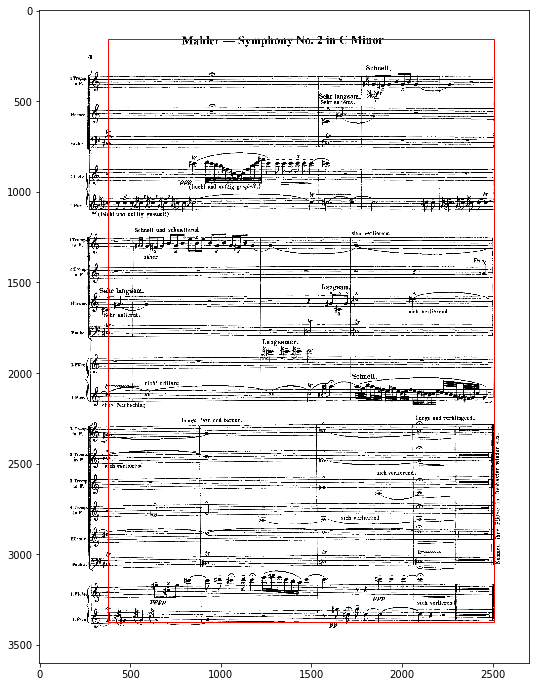

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [-4320.8511431   1209.1522825    776.80774869 ...    97.36143734
    56.36626912  5426.24916225]
rsum spectra: [[ 2075.173  +0.0000000e+00j  2210.014  +0.0000000e+00j
   2600.426  +0.0000000e+00j ...  2134.1833 +0.0000000e+00j
   2201.9292 +0.0000000e+00j  2134.1833 +0.0000000e+00j]
 [-1194.8751 -1.7053026e-13j -1050.6523 -3.3885612e+01j
   -664.04395+9.1460716e+01j ... -5189.5444 +1.6792396e+03j
  -5454.4927 +3.4194869e-14j -5189.5444 -1.6792396e+03j]
 [ 1151.03   +3.2155493e-13j  1110.6932 +6.3669312e+02j
    912.0108 +1.3695280e+03j ...  6480.021  -2.3027429e+03j
   6901.0234 +1.6077747e-13j  6480.021  +2.3027429e+03j]
 ...
 [-5988.307  -3.2155493e-13j  5452.2344 -2.3325005e+03j
  -3967.3066 +4.1620801e+03j ... -4950.4814 -2.0396768e+03j
   5402.3433 -1.6077747e-13j -4950.4814 +2.0396768e+03j]
 [ 5550.003  +1.7053026e-13j -5386.197  +1.0887540e+03j
   4922.584  -2.0732927e+03j ...  5270.687  +1.0531378e+03j
  -5430.072  -3.6859404e-14j  5270.687  -1.0531378e+03j]


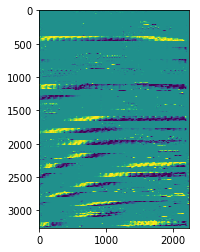

In [23]:
pic = pic_names[1]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
showImage(Irot)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot) # with 0.2 thresh
bnds = getStripBoundariesNonPiano(Icrop,debug=True)
bnds_piano = getStripBoundaries(Icrop, debug=True)

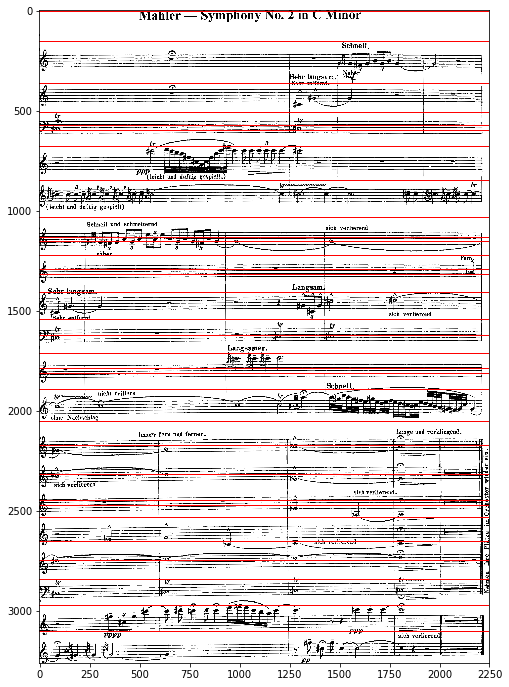

In [24]:
visualizeBoundaries(Icrop, bnds_piano)

In [17]:
pic_names[2]

'pdf/mini_dataset_png/221917_page_3.png'

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


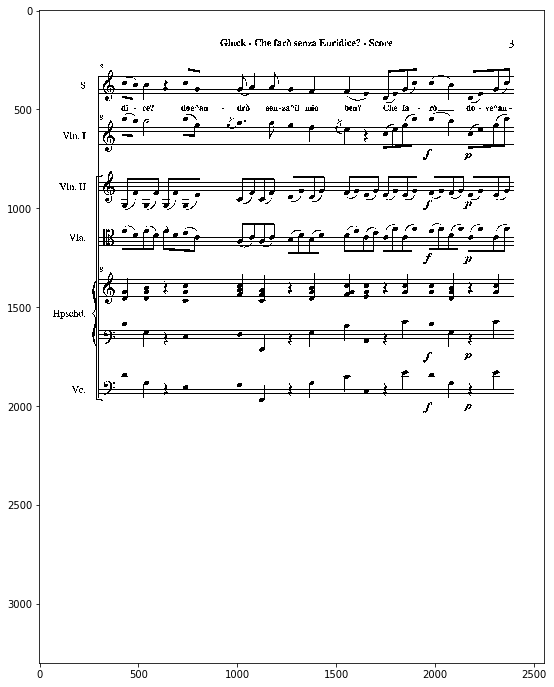

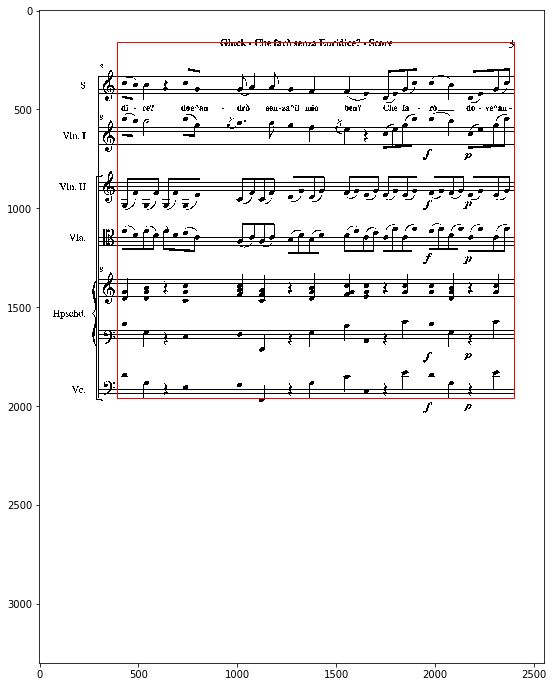

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [ 5.02755570e+03 -5.62000000e+02 -9.61000000e+02 ... -2.54268828e-13
  4.14219216e+04  3.78929920e+03]
rsum spectra: [[ 1.5097342e+01+0.00000000e+00j -1.6084681e+01+0.00000000e+00j
  -9.7883553e+01+0.00000000e+00j ...  8.4688695e+04+0.00000000e+00j
   8.5518969e+04+0.00000000e+00j  8.4688695e+04+0.00000000e+00j]
 [-1.0611604e+03+2.41584530e-13j -1.0115419e+03-4.09283081e+02j
  -8.5634515e+02-7.90230835e+02j ... -8.2075234e+04+1.61097910e+04j
  -8.4433125e+04-3.62021524e-12j -8.2075234e+04-1.61097910e+04j]
 [ 1.8856982e+03+2.74464316e-13j  1.7338207e+03+6.71393860e+02j
   1.3276552e+03+1.20205750e+03j ...  7.3211617e+04-2.95572129e+04j
   7.9710156e+04+1.00485916e-14j  7.3211617e+04+2.95572129e+04j]
 ...
 [ 5.1321812e+03-4.70906307e-14j -4.7288809e+03+1.88887280e+03j
   3.5955801e+03-3.42215723e+03j ...  6.6119750e+04+2.67353848e+04j
  -7.2002977e+04-1.00485916e-14j  6.6119750e+04-2.67353848e+04j]
 [-5.3891465e+03+9.94759830e-14j  5.2271030e+03-1.05446033e+03j
  -4.77

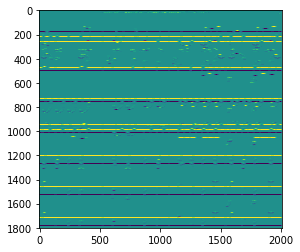

In [25]:
pic = pic_names[2]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
showImage(Irot)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot, thresh=0.2) # with 0.2 thresh
bnds = getStripBoundariesNonPiano(Icrop,debug=True)
bnds_piano = getStripBoundaries(Icrop, debug=True)

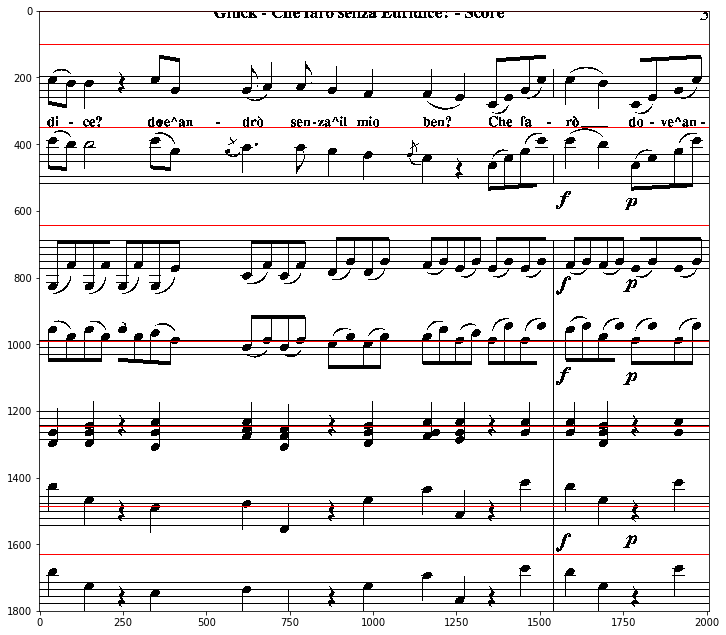

In [26]:
visualizeBoundaries(Icrop, bnds)

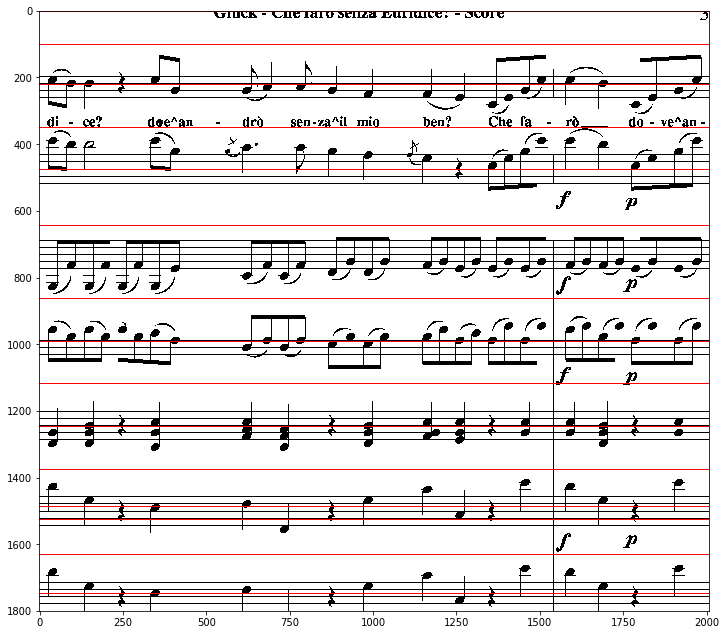

In [27]:
visualizeBoundaries(Icrop, bnds_piano)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


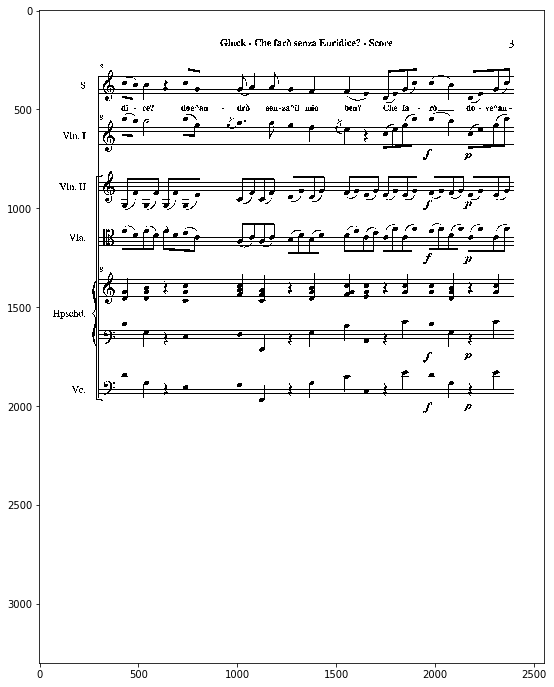

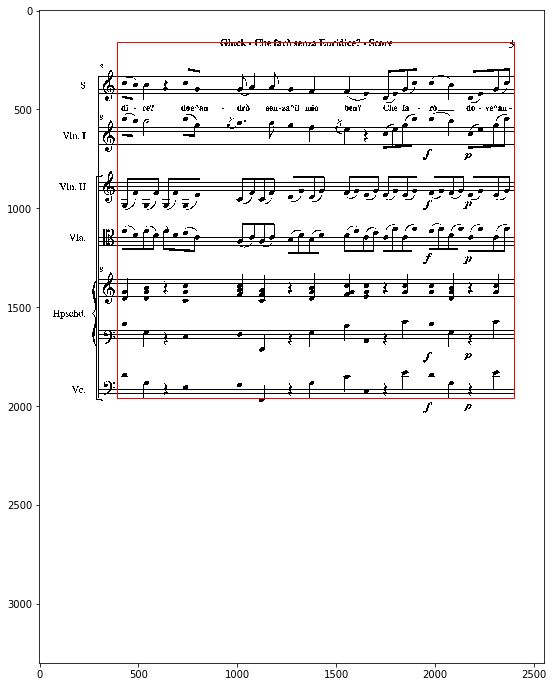

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [-873.28401422 2204.         -381.         ...  -21.          315.
 4233.28401422]
rsum spectra: [[ 4961.4326 +0.0000000e+00j  5071.7334 +0.0000000e+00j
   5401.029  +0.0000000e+00j ...  4463.9116 +0.0000000e+00j
   4514.2173 +0.0000000e+00j  4463.9116 +0.0000000e+00j]
 [ 2298.9124 -9.0949470e-13j  2043.2661 +1.8506034e+03j
   1305.2754 +3.5474404e+03j ... -4762.085  +1.0269724e+03j
  -4915.0713 +2.6645353e-14j -4762.085  -1.0269724e+03j]
 [ 1298.2987 -3.2155493e-13j   298.03018+2.4161758e+03j
  -2292.9968 +3.5816455e+03j ...  4502.638  -1.7730779e+03j
   4880.3594 +1.7240658e-15j  4502.638  +1.7730779e+03j]
 ...
 [-5089.621  +3.2155493e-13j  4600.236  -2.0348285e+03j
  -3265.0933 +3.5951775e+03j ... -3383.6838 -1.4157708e+03j
   3703.1155 -5.8567483e-14j -3383.6838 +1.4157708e+03j]
 [ 4795.0664 +4.5474735e-13j -4672.817  +8.6622809e+02j
   4316.5103 -1.6567954e+03j ...  3501.4    +7.0230719e+02j
  -3606.5183 -5.5067062e-14j  3501.4    -7.0230719e+02j]
 [-5113.0605 +

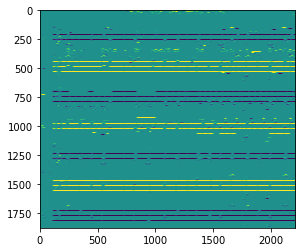

In [28]:
pic = pic_names[2]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
showImage(Irot)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot) # with regular
bnds = getStripBoundariesNonPiano(Icrop,debug=True)
bnds_piano = getStripBoundaries(Icrop, debug=True)

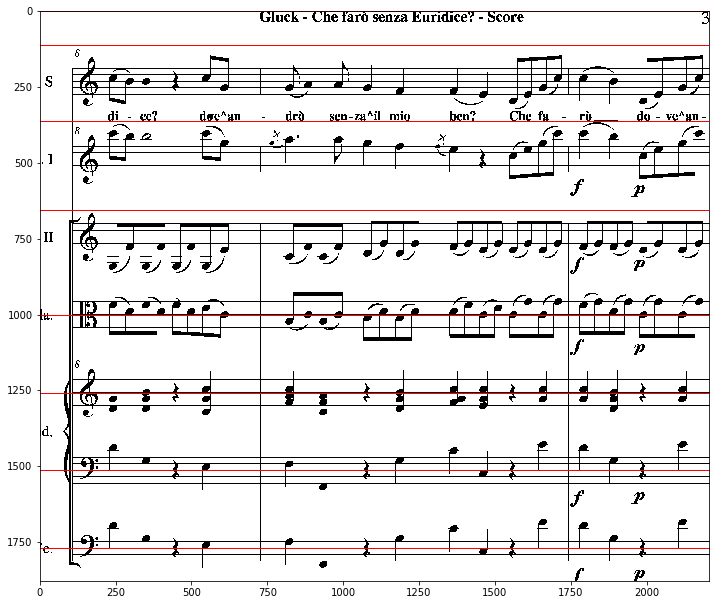

In [29]:
visualizeBoundaries(Icrop, bnds)

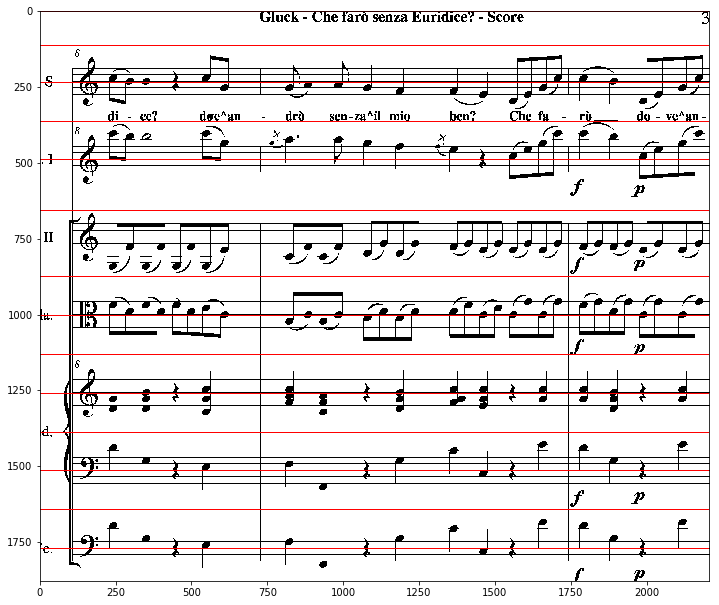

In [30]:
visualizeBoundaries(Icrop, bnds_piano)

In [32]:
bnds_piano

[0,
 112,
 232,
 361,
 488,
 655,
 873,
 1001,
 1129,
 1258,
 1386,
 1513,
 1640,
 1768,
 1877]

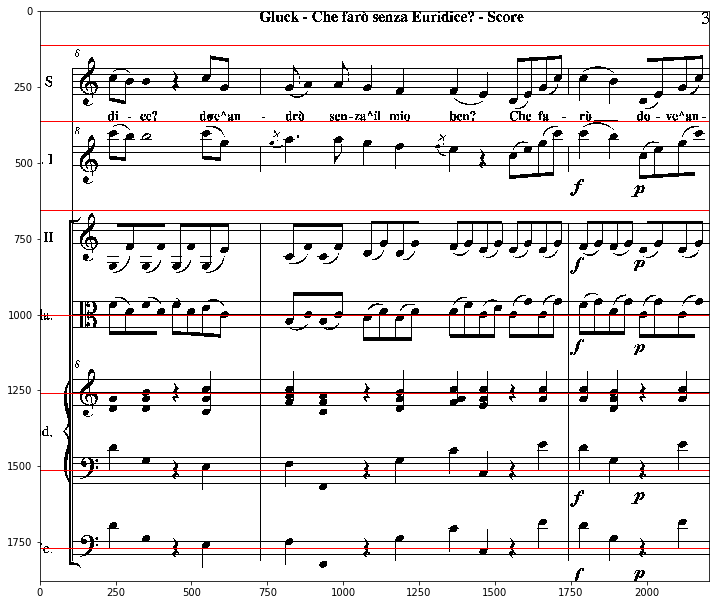

In [33]:
visualizeBoundaries(Icrop, bnds_piano[1::2])

Types of errors:
1. Strips segmented correctly in some parts of page, not in others
    - Missing staff lines in parts of some images because of Python import + twiddling with matrix values--affects detection of note locations / pixels
    - importing to python loses some potentially important information e.g. staff lines. Since we are losing a whole staff line and our algorithm to detec these relies on the pixels at a vertical location of the image to get a peak, that could affect where the center of the peak lies and generate an incorrect midpoint.
    
2. Consistently incorrect segmentation of strips (segmentation line goes through a line of music)
    - Original scan quality not high / contains noise
    - Some/many staff lines not detected in picture. 
    
3. Missing lines / segmentations
    - Python import degrades img quality by a small amt

In [18]:
pic = pic_names[2]

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


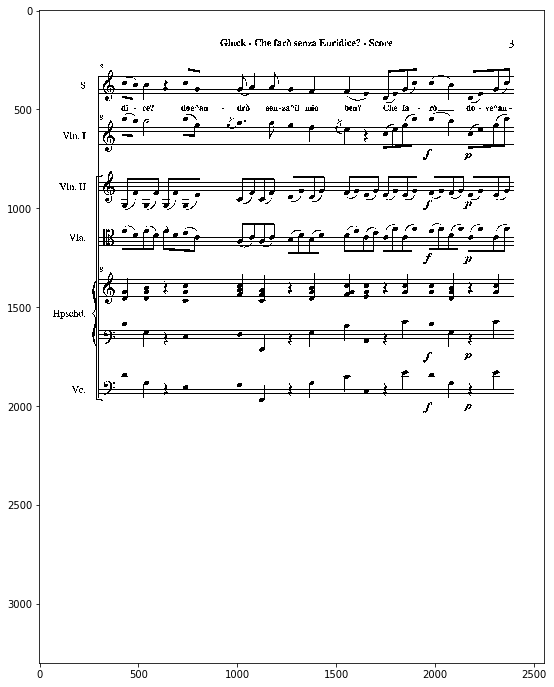

In [19]:
I = importImage(pic)
showImage(I)
# Irot, theta = rotateToHorizontal(I)
# showImage(Irot)
# ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
# print("showing bounding box image...")
# showImageWithBB(Irot, ll, bbw, bbh)
# Icrop = getCropped(Irot, thresh=0.2) # with 0.2 thresh
# bnds = getStripBoundariesNonPiano(Icrop,debug=True)
# bnds_piano = getStripBoundaries(Icrop, debug=True)

In [31]:
from scipy.misc import imread
image = imread(pic, flatten=True, mode='L')

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


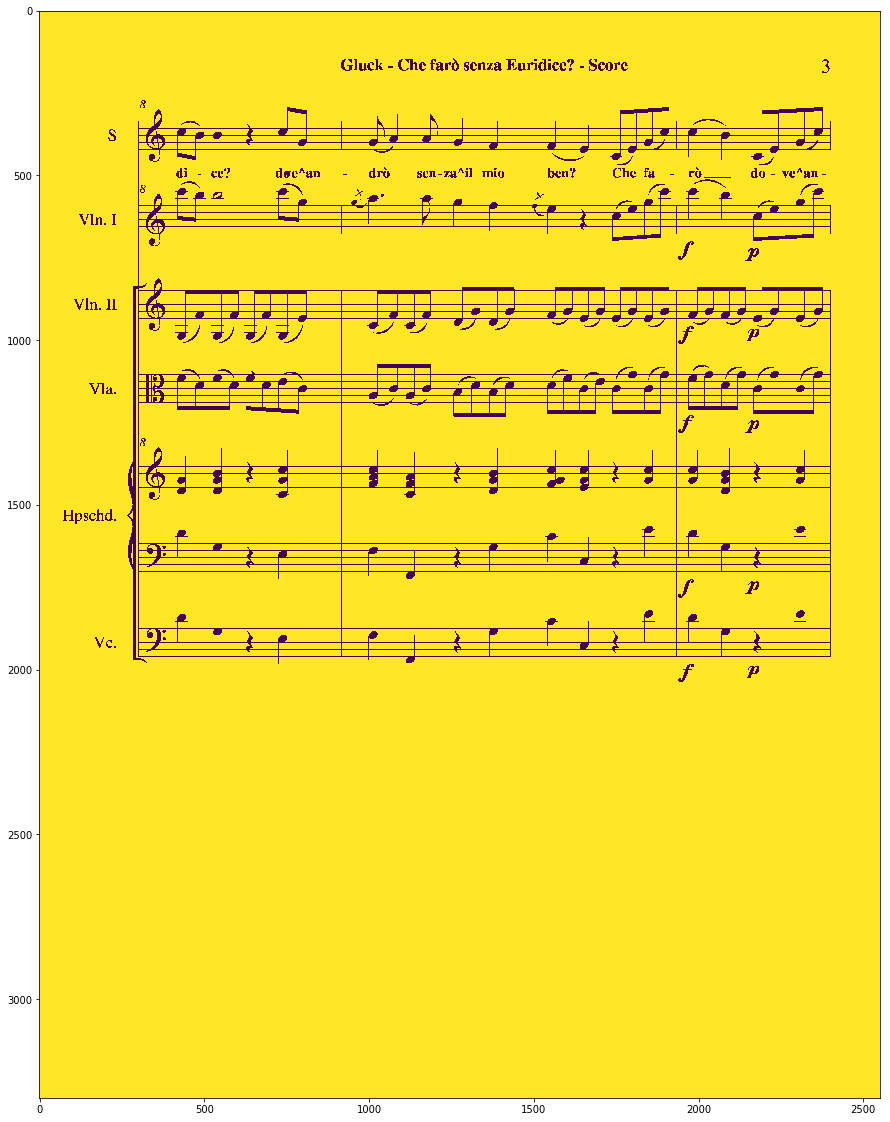

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(image)

In [36]:
image.shape

(3300, 2550)

In [37]:
image

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

In [38]:
image = 1 - image/255.0 # make white -> 0, black -> 1

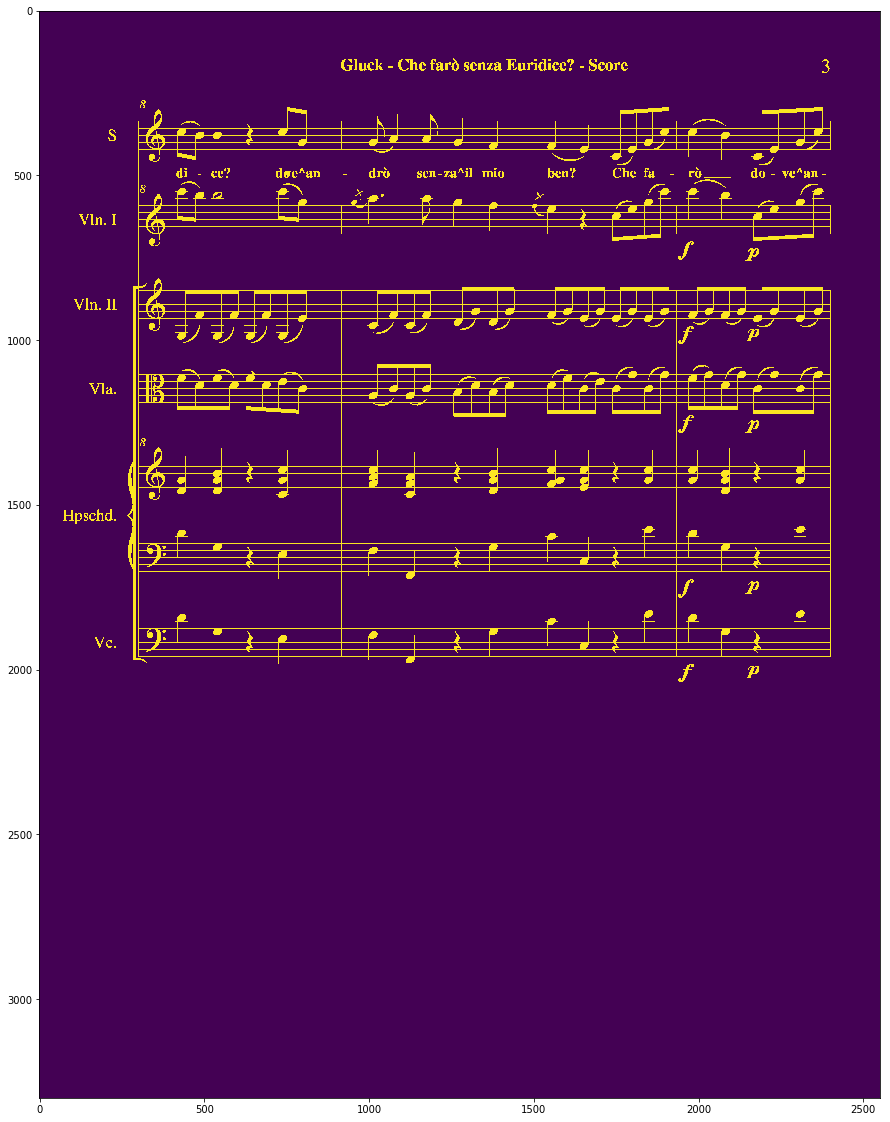

In [39]:
plt.figure(figsize=(20,20))
plt.imshow(image)

In [44]:
pic_names[2]

'pdf/mini_dataset_png/221917_page_3.png'

In [46]:
import subprocess
# problem is ht of pg compared to width, try to convert w 600 dpi instead of 300.
to_convert = 'pdf/mini_dataset_pdf/221917_page_3.pdf'
final_name = '221917_page_3_600dpi.png'
subprocess.call(['convert', '-density', '600', to_convert, final_name])

0

In [47]:
I = importImage(final_name)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


In [49]:
image = imread(pic, flatten=True, mode='L')

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


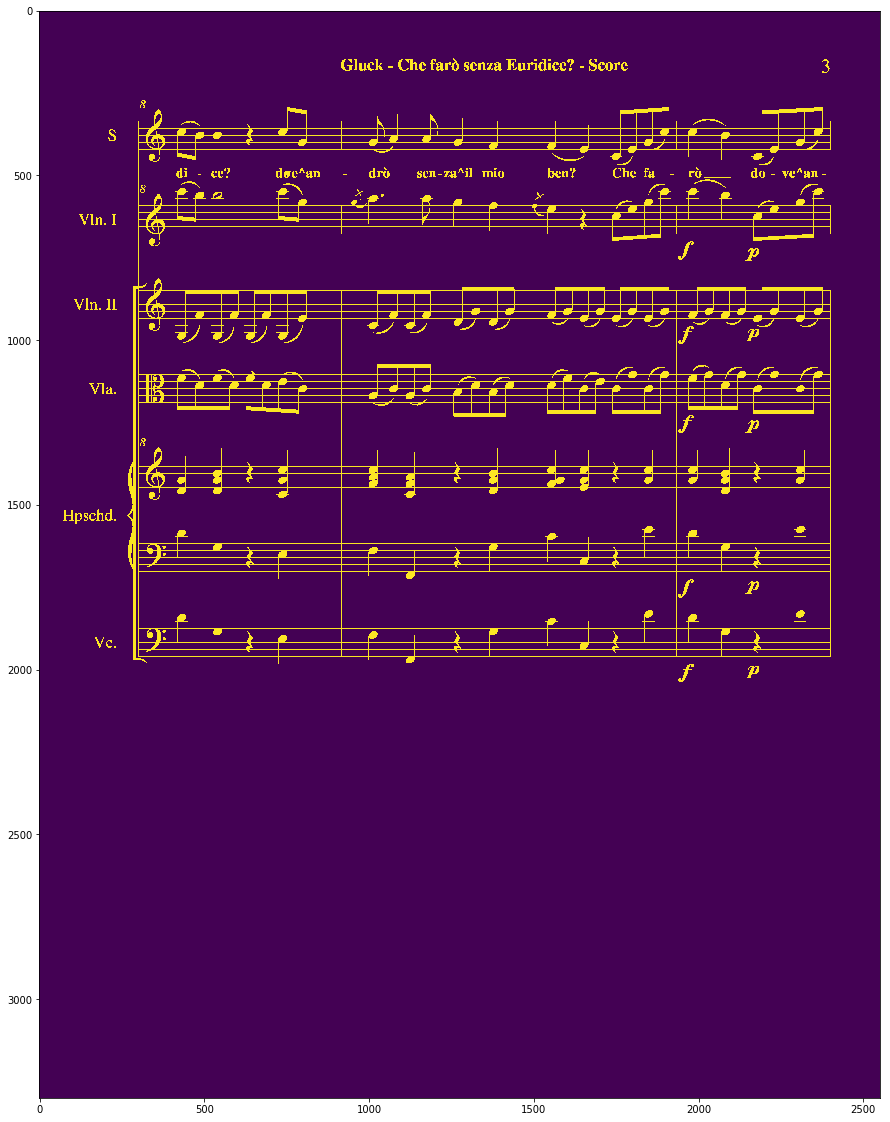

In [50]:
image = 1 - image/255.0 # make white -> 0, black -> 1
plt.figure(figsize=(20,20))
plt.imshow(image)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [ 5.02755570e+03 -5.62000000e+02 -9.61000000e+02 ... -2.54268828e-13
  4.14219216e+04  3.78929920e+03]
rsum spectra: [[ 1.5097342e+01+0.00000000e+00j -1.6084681e+01+0.00000000e+00j
  -9.7883553e+01+0.00000000e+00j ...  8.4688695e+04+0.00000000e+00j
   8.5518969e+04+0.00000000e+00j  8.4688695e+04+0.00000000e+00j]
 [-1.0611604e+03+2.41584530e-13j -1.0115419e+03-4.09283081e+02j
  -8.5634515e+02-7.90230835e+02j ... -8.2075234e+04+1.61097910e+04j
  -8.4433125e+04-3.62021524e-12j -8.2075234e+04-1.61097910e+04j]
 [ 1.8856982e+03+2.74464316e-13j  1.7338207e+03+6.71393860e+02j
   1.3276552e+03+1.20205750e+03j ...  7.3211617e+04-2.95572129e+04j
   7.9710156e+04+1.00485916e-14j  7.3211617e+04+2.95572129e+04j]
 ...
 [ 5.1321812e+03-4.70906307e-14j -4.7288809e+03+1.88887280e+03j
   3.5955801e+03-3.42215723e+03j ...  6.6119750e+04+2.67353848e+04j
  -7.2002977e+04-1.00485916e-14j  6.6119750e+04-2.67353848e+04j]
 [-5.3891465e+03+9.94759830e-14j  5.2271030e+03-1.05446033e+03j
  -4.77

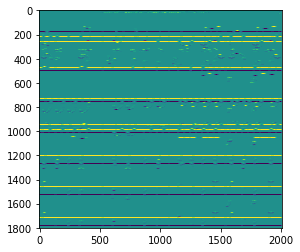

In [40]:
I = image
Irot, theta = rotateToHorizontal(I)
Icrop = getCropped(Irot, thresh=0.2) # with 0.2 thresh
bnds = getStripBoundariesNonPiano(Icrop,debug=True)
bnds_piano = getStripBoundaries(Icrop, debug=True)

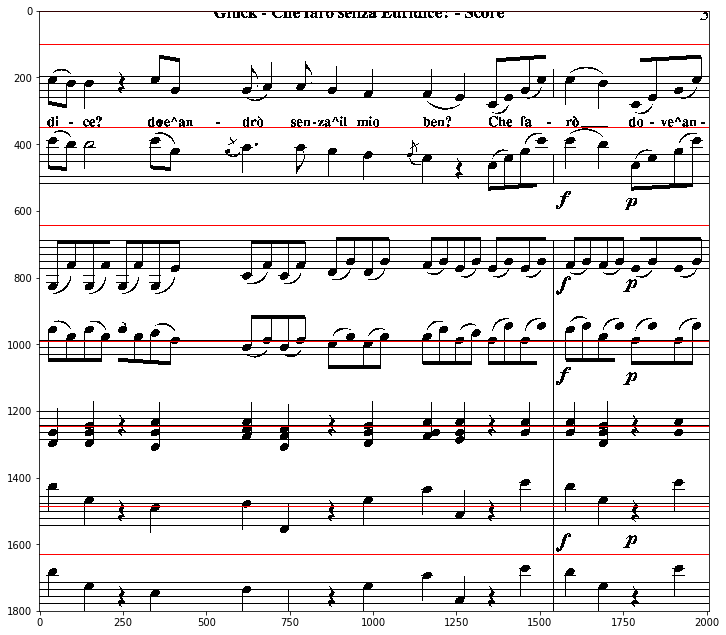

In [41]:
visualizeBoundaries(Icrop, bnds)

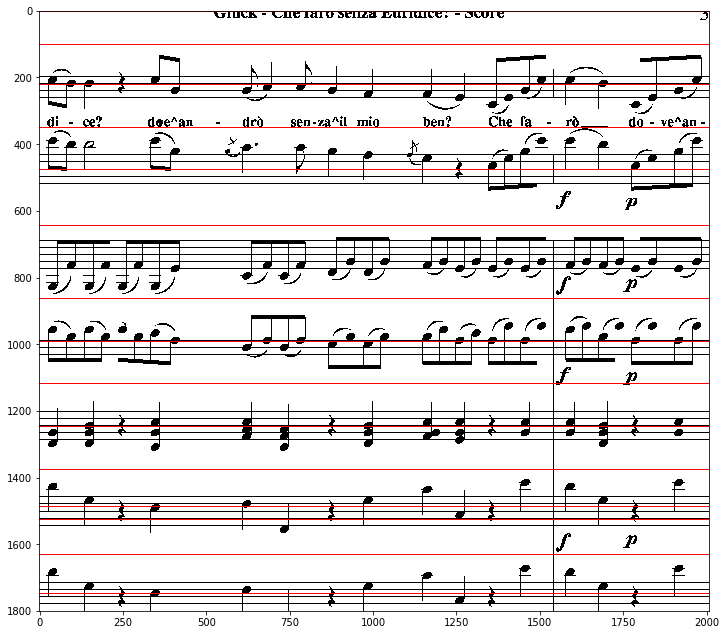

In [42]:
visualizeBoundaries(Icrop, bnds_piano)

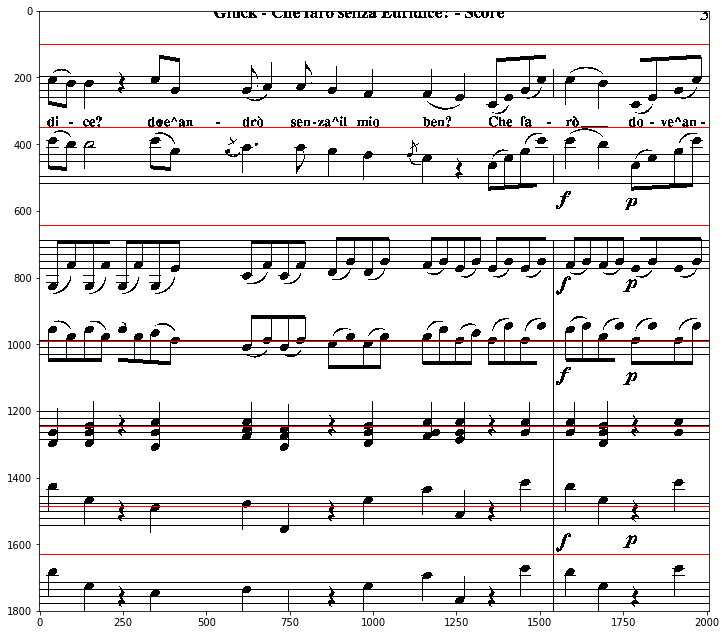

In [43]:
visualizeBoundaries(Icrop, bnds_piano[1::2])

In [52]:
pic = pic_names[3]

In [53]:
I = importImage(pic)

TypeError: imread() got an unexpected keyword argument 'flatten'